In [14]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# Define the current directory if __file__ is not available
current_dir = os.getcwd()  # Gets the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Moves one level up

# Add the parent directory to the Python path
sys.path.insert(0, parent_dir)

from preprocessing import *
from save_and_compare_results import *

In [ ]:
# Define the path to the parent directory
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Move one level up

# 1. Choose the phenotype

In [ ]:
phenotype = "YPD_doublingtime"
#phenotype = "YPDCUSO410MM_40h"

# 2. Preprocess the data

In [ ]:
X = pd.read_pickle(os.path.join(data_dir, f"data/X_matrix_restricted_{phenotype}.pkl"))
Y = pd.read_csv(os.path.join(data_dir, f"data/y_{phenotype}.csv"))

In [ ]:
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())

X, Y = shuffle_dataset(X,Y)

# 3. Run the model

In [17]:
param_grid = {
    "n_estimators": [200, 500],  
    "max_depth": [40],      
    "min_samples_split": [2, 5], 
    "min_samples_leaf": [2, 4],  
    "max_features": ["sqrt", "log2" ] 
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [18]:
print("Training of Random Forest with hyperparameters tuning")
grid_search.fit(X, Y.values.ravel())

Training of Random Forest with hyperparameters tuning
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END max_depth=40, max_features=sqrt, min

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [40], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 500]},
             scoring='r2', verbose=2)

In [19]:
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest hyperparameters :", best_params)


Best hyperparameters : {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}


In [20]:
y_pred = best_rf.predict(X)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
print(f"\nR² Score: {r2:.4f}, Mean Squared Error: {mse:.4f}")


R² Score: 0.4260, Mean Squared Error: 0.0288


With numbers :  
Best hyperparameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}  
R² Score: 0.6012, Mean Squared Error: 0.0200

With binary :   
Best hyperparameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}  
R² Score: 0.6233, Mean Squared Error: 0.0189

With restrained dataset :  
Best hyperparameters : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}  
R² Score: 0.4205, Mean Squared Error: 0.0291

# 4. Only plot the top 20 mutations


Top 10 Features Impacting YPD Doubling Time:
               Feature  Importance
4159         YLR154C-H    0.014512
4160         YLR154W-F    0.014020
2689   YJL218W_53_L->I    0.009248
4175           YLR467W    0.009136
4128       YJR153W_CNV    0.007933
4083       YHR043C_CNV    0.007611
4176     YML009C-A_CNV    0.007352
406   YBR230W-A_4_G->D    0.007075
4203       YNL170W_CNV    0.006565
4073       YGR291C_CNV    0.006513
4078     YHL048C-A_CNV    0.006172
4074       YGR292W_CNV    0.006041
4146       YLL020C_CNV    0.005954
4212       YNR072W_CNV    0.005930
3980       YCR102C_CNV    0.005743
4104     YIR018C-A_CNV    0.005734
4075       YGR293C_CNV    0.005621
4084           YHR055C    0.005502
4179     YML057C-A_CNV    0.005461
4094       YHR216W_CNV    0.005314


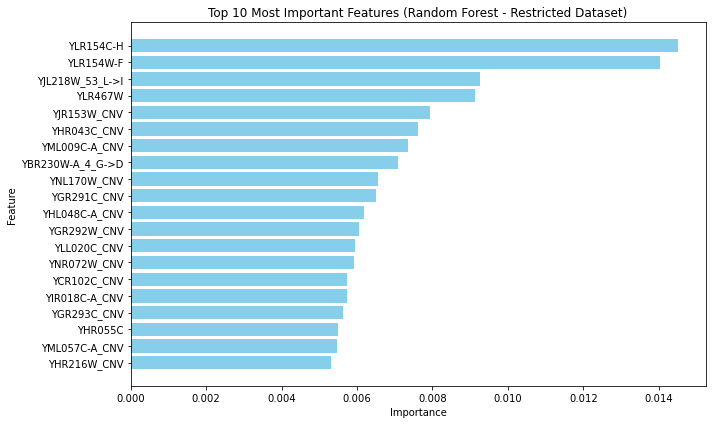

In [21]:
# Extract feature importance
feature_importances = best_rf.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
feature_importances_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Select the top 10 most important features
top_features = feature_importances_df.head(20)

# Display the top 10 features in the console
print("\nTop 10 Features Impacting YPD Doubling Time:")
print(top_features)

# Plot the top 10 feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features (Random Forest - Restricted Dataset)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
save_feature_importance(
        features=features,
        importance_scores=feature_importances,
        method="RandomForest",
        model_name="mutations"
    )

Feature importance saved to ../results/mutations_RandomForest_importance.csv


# 5. Model features importance

Saving RF feature importances...
Feature importance saved to ../results/RandomForest_model_importance.csv
Displaying top 10 features...

Top 10 Features Impacting YPD Doubling Time:
               Feature  Importance
4159         YLR154C-H    0.014512
4160         YLR154W-F    0.014020
2689   YJL218W_53_L->I    0.009248
4175           YLR467W    0.009136
4128       YJR153W_CNV    0.007933
4083       YHR043C_CNV    0.007611
4176     YML009C-A_CNV    0.007352
406   YBR230W-A_4_G->D    0.007075
4203       YNL170W_CNV    0.006565
4073       YGR291C_CNV    0.006513


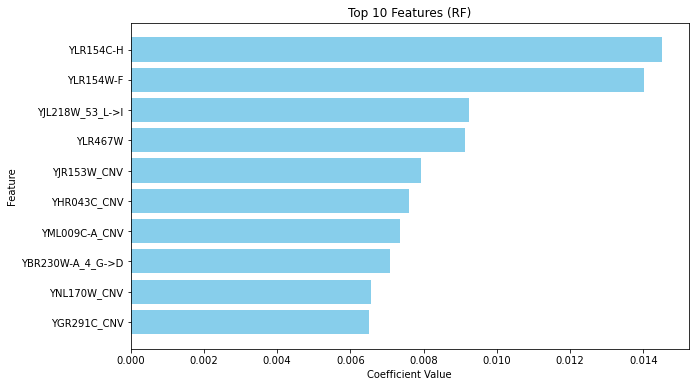

In [12]:
# Save feature importance from RF
print("Saving RF feature importances...")
save_feature_importance(
    features=X.columns,
    importance_scores=best_rf.feature_importances_,
    method="model",
    model_name="RandomForest"
)

# Display and plot the top 10 features
print("Displaying top 10 features...")
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_features = feature_importances_df.head(10)

print("\nTop 10 Features Impacting YPD Doubling Time:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Features (RF)")
plt.gca().invert_yaxis()
plt.show()

# 6. SHAP features importance

Calcul of SHAP values...


 98%|===================| 780/792 [00:50<00:00]        

Saving SHAP feature importances for Random Forest...
Feature importance saved to ../results/RandomForest_SHAP_importance.csv
Generating SHAP summary plots for RF...


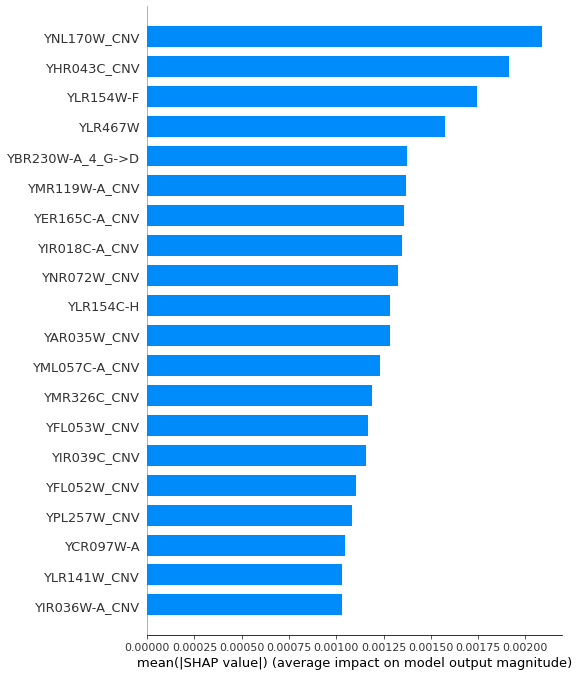

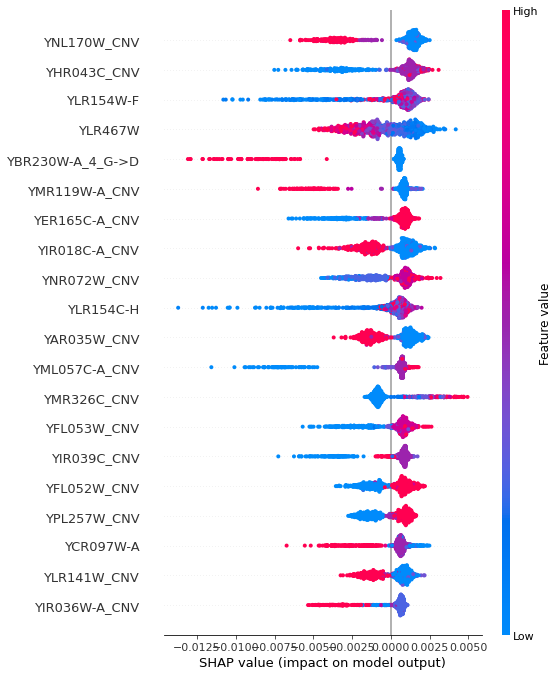

In [13]:
print("Calcul of SHAP values...")
explainer = shap.Explainer(best_rf, X)
shap_values = explainer(X)
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)

# Sauvegarder les importances SHAP
print("Saving SHAP feature importances for Random Forest...")
save_feature_importance(
    features=X.columns,
    importance_scores=shap_mean_importance,
    method="SHAP",
    model_name="RandomForest"
)

# %%
# Graphiques SHAP
print("Generating SHAP summary plots for RF...")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)